# Explore population outbreaks in Fringilla insect data 

Due to high number of missing values, this line of research focusses on the years from 1998 to 2020.

**This version of the notebook includes major updates to the data analysis, such as MAD for outbreak classification and separating seasons (into 1st and 2nd half) based on the minimum seasonal count.**

In [12]:
# import libraries
from datetime import datetime
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle as pkl
sns.set_theme(
    style="darkgrid",
    color_codes=True,
    palette='Dark2',
)
from matplotlib import cm, colors
from scipy.stats import median_abs_deviation

In [13]:
# get hex color codes of Dark2 matplotlib colormap
cmap = cm.get_cmap('Dark2', 8)
hex = []
for i in range(cmap.N):
    rgba = cmap(i)
    # convert rgb(a) to hex
    hex.append(colors.rgb2hex(rgba))

### DATA IMPORT

In [14]:
# data import
count_daily = pd.read_csv('../../data/all_species_count_daily.csv',
                          parse_dates=['date'])

count_by_trap = pd.read_csv('../../data/all_species_count_by_trap.csv',
                            parse_dates=['date'])

# focus on years 1998 to 2020
count_daily = count_daily[count_daily.year >= 1998].reset_index(drop=True)

count_daily

,species,date,day,month,year,count,tmp,cloud,wind_dir
0,Vanessa atalanta,1998-04-01,1,4,1998,NaN,NaN,NaN,NaN
1,Vanessa atalanta,1998-04-02,2,4,1998,NaN,NaN,NaN,NaN
2,Vanessa atalanta,1998-04-03,3,4,1998,NaN,NaN,NaN,NaN
3,Vanessa atalanta,1998-04-04,4,4,1998,NaN,NaN,NaN,NaN
4,Vanessa atalanta,1998-04-05,5,4,1998,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
74170,Pararge aegeria,2020-10-28,28,10,2020,NaN,NaN,NaN,NaN
74171,Pararge aegeria,2020-10-29,29,10,2020,NaN,NaN,NaN,NaN
74172,Pararge aegeria,2020-10-30,30,10,2020,NaN,NaN,NaN,NaN
74173,Pararge aegeria,2020-10-31,31,10,2020,NaN,NaN,NaN,NaN


In [15]:
%store -r all_species

from pandas.testing import assert_frame_equal
assert_frame_equal(
    count_daily[['species', 'year', 'count']],
    all_species[['species', 'year', 'count']]
)

### MEAN SEASONAL PATTERN (to temporally locate outbreaks)

In [16]:
# computing accumulated count for fixed number of observations (i.e., days)
moving_window_size = 21

accumulated_counts = (
    count_daily
    .groupby(['species', 'year'], as_index=False) # rememeber: groupby alters order
    .rolling(window=moving_window_size,           # of species alphabetically!
             min_periods=1,
             center=True)
    ['count'].sum()
    .sort_index(level=2)
    .values
)

count_daily['count_sum'] = accumulated_counts

count_daily

,species,date,day,month,year,count,tmp,cloud,wind_dir,count_sum
0,Vanessa atalanta,1998-04-01,1,4,1998,NaN,NaN,NaN,NaN,0.0
1,Vanessa atalanta,1998-04-02,2,4,1998,NaN,NaN,NaN,NaN,0.0
2,Vanessa atalanta,1998-04-03,3,4,1998,NaN,NaN,NaN,NaN,0.0
3,Vanessa atalanta,1998-04-04,4,4,1998,NaN,NaN,NaN,NaN,0.0
4,Vanessa atalanta,1998-04-05,5,4,1998,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...
74170,Pararge aegeria,2020-10-28,28,10,2020,NaN,NaN,NaN,NaN,0.0
74171,Pararge aegeria,2020-10-29,29,10,2020,NaN,NaN,NaN,NaN,0.0
74172,Pararge aegeria,2020-10-30,30,10,2020,NaN,NaN,NaN,NaN,0.0
74173,Pararge aegeria,2020-10-31,31,10,2020,NaN,NaN,NaN,NaN,0.0


In [17]:
# computing mean count per day (i.e., per fixed number of observations)
count_daily_mean = (
    count_daily
    .groupby(['species', 'month', 'day'], as_index=False)
    ['count_sum'].mean()
)

# the quick & dirty way to get a datetime object column, which is needed for
# plotting soon
count_daily_mean['year'] = 1900
count_daily_mean['dummy_date'] = pd.to_datetime(count_daily_mean[['year', 'month', 'day']])
count_daily_mean = count_daily_mean.drop('year', axis=1)
count_daily_mean

,species,month,day,count_sum,dummy_date
0,Aglais urticae,4,1,0.200000,1900-04-01
1,Aglais urticae,4,2,0.190476,1900-04-02
2,Aglais urticae,4,3,0.190476,1900-04-03
3,Aglais urticae,4,4,0.238095,1900-04-04
4,Aglais urticae,4,5,0.227273,1900-04-05
...,...,...,...,...,...
3220,Vanessa cardui,10,28,0.043478,1900-10-28
3221,Vanessa cardui,10,29,0.043478,1900-10-29
3222,Vanessa cardui,10,30,0.043478,1900-10-30
3223,Vanessa cardui,10,31,0.045455,1900-10-31


['1900-07-13T00:00:00.000000000']


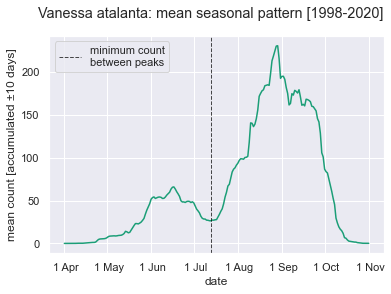

In [18]:
SPECIES = 'Vanessa atalanta'

# find minimum count & date in July --------------------------------------------
count_july = count_daily_mean[(count_daily_mean.month == 7)
                              & (count_daily_mean.species == SPECIES)]

min_date = count_july[count_july.count_sum == count_july.count_sum.min()]['dummy_date'].values
print(min_date)
# ------------------------------------------------------------------------------

# plotting
data = count_daily_mean[count_daily_mean['species'].isin([SPECIES])] 

fig, ax = plt.subplots()
sns.lineplot(data=data, x='dummy_date', y='count_sum', ax=ax)

# Define the date format -----------------
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%e %b")
ax.xaxis.set_major_formatter(date_form)
#fig.autofmt_xdate()
# ----------------------------------------

ax.axvline(x=min_date, lw=1, ls='--', c='k', alpha=0.7, label='minimum count\nbetween peaks')
ax.legend()
ax.set_ylabel(f'mean count [accumulated ±{int((moving_window_size-1)/2)} days]')
ax.set_xlabel('date')
fig.suptitle(f'{SPECIES}: mean seasonal pattern [1998-2020]')
fig.savefig('../figs/kaliningrad/vatalanta/outbreaks_mean-seasonal-pattern-upd.png', 
            dpi=600, bbox_inches='tight')

### OUTBREAKS BY SEASON

This time, split the outbreak index into two halfs corresponding to the two peaks in the previous plot. For the sake of simplicity, I refer to these as spring and autumn within the dataset.

In [19]:
count_daily

,species,date,day,month,year,count,tmp,cloud,wind_dir,count_sum
0,Vanessa atalanta,1998-04-01,1,4,1998,NaN,NaN,NaN,NaN,0.0
1,Vanessa atalanta,1998-04-02,2,4,1998,NaN,NaN,NaN,NaN,0.0
2,Vanessa atalanta,1998-04-03,3,4,1998,NaN,NaN,NaN,NaN,0.0
3,Vanessa atalanta,1998-04-04,4,4,1998,NaN,NaN,NaN,NaN,0.0
4,Vanessa atalanta,1998-04-05,5,4,1998,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...
74170,Pararge aegeria,2020-10-28,28,10,2020,NaN,NaN,NaN,NaN,0.0
74171,Pararge aegeria,2020-10-29,29,10,2020,NaN,NaN,NaN,NaN,0.0
74172,Pararge aegeria,2020-10-30,30,10,2020,NaN,NaN,NaN,NaN,0.0
74173,Pararge aegeria,2020-10-31,31,10,2020,NaN,NaN,NaN,NaN,0.0


In [20]:
def which_season(row):
    if row['month'] < 7:   # define spring as
        val = 'spring'     # april to june, skip
    elif row['month'] > 7: # july, and autumn from
        val = 'autumn'     # august to october
    else:
        if row['day'] <= 13:
            val = 'spring'
        else:
            val='autumn'
    return val

def divide_outbreaks_into_seasons(df):
    # add column with spring/summer
    df['season'] = df.apply(which_season, axis='columns')
    
    # sum up counts per season
    df = df.groupby(['species', 'year', 'season'], as_index=False)['count'].sum()

    # compute average count across all years
    df = df.join(
        df.groupby(['species', 'season'])['count'].median(),
        on=['species', 'season'],
        rsuffix='_avg'
    )
    # compute median absolute deviation (MAD)
    df = df.join(
        df.groupby(['species', 'season'])['count'].apply(median_abs_deviation, scale='normal'),
        on=['species', 'season'],
        rsuffix='_mad'
    )
    
    # computing outbreak index with zero reflecting the total average count
    df['index'] = df['count'] - df['count_avg']
    return df

outbreaks_season = divide_outbreaks_into_seasons(count_daily)

In [23]:
# define a level of decision
# NOTE: Why choosing 2?
mad_factor = 2.5

# test for significance
def above_threshold(row, column_label):
    threshold = mad_factor * row[column_label]
    return abs(row['count']) > threshold

outbreaks_season['signi'] = outbreaks_season.apply(above_threshold, axis='columns', column_label='count_mad')
outbreaks_season[(outbreaks_season.signi) & (outbreaks_season.species == 'Vanessa atalanta')]

,species,year,season,count,count_avg,count_mad,index,signi
598,Vanessa atalanta,1998,autumn,1328.0,439.0,467.019699,889.0,True
604,Vanessa atalanta,2001,autumn,1807.0,439.0,467.019699,1368.0,True
607,Vanessa atalanta,2002,spring,322.0,82.0,91.921338,240.0,True
628,Vanessa atalanta,2013,autumn,1328.0,439.0,467.019699,889.0,True
635,Vanessa atalanta,2016,spring,247.0,82.0,91.921338,165.0,True
639,Vanessa atalanta,2018,spring,409.0,82.0,91.921338,327.0,True
641,Vanessa atalanta,2019,spring,296.0,82.0,91.921338,214.0,True


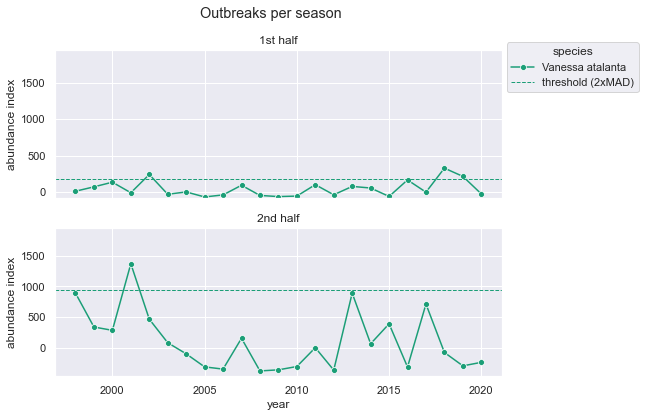

In [22]:
# plotting
data = outbreaks_season[
    (outbreaks_season['species'] == 'Vanessa atalanta') 
    #| (outbreaks_season['species'] == 'Vanessa cardui')
    #| (outbreaks_season['species'] == 'Inachis io')
]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,6))
sns.lineplot(data=data[data.season == 'spring'], x='year', y='index',
             hue='species', marker='o', ax=axs[0], legend=False, label='Vanessa atalanta')
sns.lineplot(data=data[data.season == 'autumn'], x='year', y='index',
             hue='species', marker='o', ax=axs[1], legend=False)

# plot threshold ---------------------------------------------------------------
axs[0].axhline(
    y=outbreaks_season[(outbreaks_season.species == 'Vanessa atalanta')
                       & (outbreaks_season.season == 'spring')]
                      ['count_mad'].unique() * mad_factor,
    ls='--', lw=1, c=hex[0], label=f'threshold ({mad_factor}xMAD)'
)
axs[1].axhline(
    y=outbreaks_season[(outbreaks_season.species == 'Vanessa atalanta')
                       & (outbreaks_season.season == 'autumn')]
                      ['count_mad'].unique() * mad_factor,
    ls='--', lw=1, c=hex[0]
)
# ------------------------------------------------------------------------------

axs[0].set_title('1st half')
axs[1].set_title('2nd half')

for i in range(len(axs)):
    axs[i].set_ylabel('abundance index')
    axs[i].set_ylim(top=1950)
fig.legend(title='species', loc='center left', bbox_to_anchor=(0.9, 0.84))
fig.suptitle('Outbreaks per season')
fig.savefig('../figs/kaliningrad/vatalanta/outbreaks_per-season-upd.png', 
            dpi=600, bbox_inches='tight')